# NLP Project
## Sentiment Analysis with BERT on Movie Reviews

[IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

Team Memebers:
- Chihabeddine Zitouni
- Patrick Molina
- Małgorzata Gierdewicz

### Step 0: Environment SetUp & Configuration

In [1]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import Utils as utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
MODEL_NAME = 'bert-base-uncased'
MODEL_PATH = 'bert_sentiment_model.pt'
DATA_PATH = 'data/imdb_dataset.csv'

### Step 1: Data Preperation

- Load and preprocess data

In [4]:
data = utils.load_data(DATA_PATH)
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data = utils.clean_df(data, ['review'])
data = utils.map_labels(data, 'sentiment', {'positive': 1, 'negative': 0})

data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


- Train/Test Split

In [6]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

### Step 2: Dataset and Tokenization

- Bert Tokenizer

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

- Create Datasets and Dataloaders

In [8]:
train_dataset = utils.MovieReviewDataset(train_df['review'], train_df['sentiment'], tokenizer, MAX_LENGTH)
test_dataset = utils.MovieReviewDataset(test_df['review'], test_df['sentiment'], tokenizer, MAX_LENGTH)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Step 3: Model Setup

- Defining the Optimizer

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

- Training loop

In [11]:
model.train()
train_losses = []

In [12]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()
    print(f"  Loss: {loss.item():.4f}")

Epoch 1/3
  Loss: 0.3216
Epoch 2/3
  Loss: 0.1166
Epoch 3/3
  Loss: 0.2965


### Step 4: Model Evaluation

In [13]:
model.eval()
all_preds = []
all_labels = []

In [14]:
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

- Calculate evaluation metrics

In [15]:
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)

In [16]:
print("\nEvaluation Results:")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)


Evaluation Results:
Accuracy: 0.8957
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      4961
           1       0.87      0.93      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



- Training Loss Plot

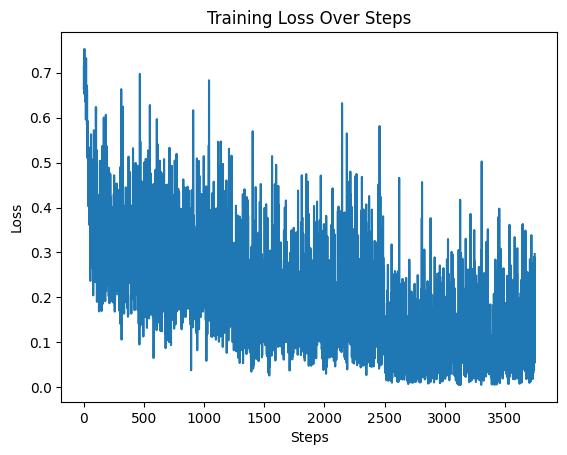

In [17]:
plt.plot(train_losses)
plt.title("Training Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()

- Confusion Matrix

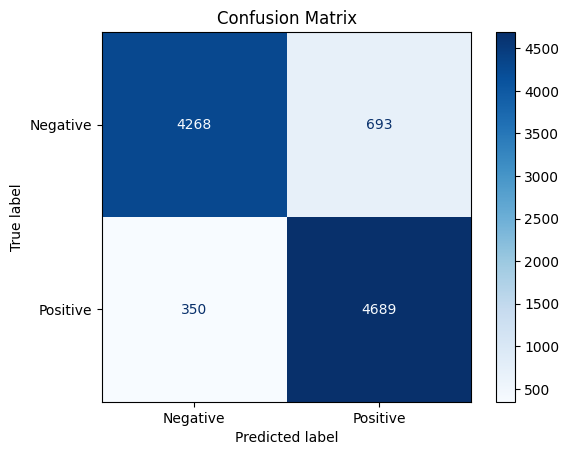

In [18]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

- Classification Report as Table

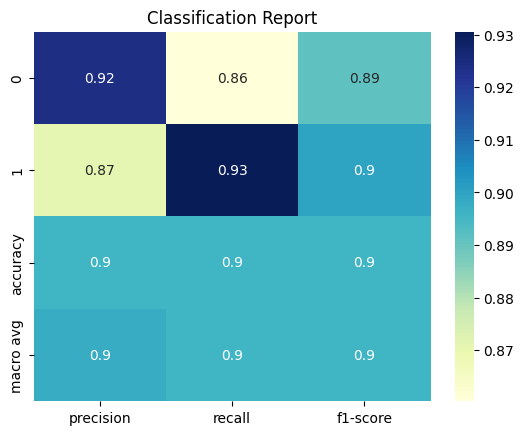

In [19]:
report_dict = classification_report(all_labels, all_preds, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu")
plt.title("Classification Report")
plt.show()

### Step 5: Prediciton Example

In [20]:
def predict_sentiment(text):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        outputs = model(encoding['input_ids'], attention_mask=encoding['attention_mask'])
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        return "Positive" if prediction == 1 else "Negative"

- Test with few Examples

In [21]:
review1 = "This movie was absolutely fantastic! The acting was superb and the story was captivating."
print(f"Review: {review1} -> Sentiment: {predict_sentiment(review1)}")

Review: This movie was absolutely fantastic! The acting was superb and the story was captivating. -> Sentiment: Positive


In [22]:
review2 = "I found this film to be quite boring and the plot was predictable. Not a fan."
print(f"Review: {review2} -> Sentiment: {predict_sentiment(review2)}")

Review: I found this film to be quite boring and the plot was predictable. Not a fan. -> Sentiment: Negative


In [23]:
review3 = "It had some good moments, but overall it was just okay."
print(f"Review: {review3} -> Sentiment: {predict_sentiment(review3)}")

Review: It had some good moments, but overall it was just okay. -> Sentiment: Negative


### Step 6: Exporting the model

In [24]:
torch.save(model.state_dict(), 'sentiment_analysis_model_3ep_11_05.pth')
tokenizer.save_pretrained("./tokenizer")
print("Model saved successfully!")

Model saved successfully!
